In [1]:
import os
import json
from iqcc_cloud_client import IQCC_Cloud

# Set your quantum computer backend
quantum_computer_backend = "gilboa"  # for example qc_qwfix
iqcc = IQCC_Cloud(quantum_computer_backend=quantum_computer_backend)
# Get the latest state and wiring files
latest_wiring = iqcc.state.get_latest("wiring")
latest_state = iqcc.state.get_latest("state")

# Get the state folder path from environment variable
quam_state_folder_path = os.environ["QUAM_STATE_PATH"]

# Save the files
with open(os.path.join(quam_state_folder_path, "wiring.json"), "w") as f:
    json.dump(latest_wiring.data, f, indent=4)

with open(os.path.join(quam_state_folder_path, "state.json"), "w") as f:
    json.dump(latest_state.data, f, indent=4)

2025-06-02 22:57:12,897 - qm - INFO     - Starting session: 34d49ce0-344d-4878-b947-f0110afd5864


In [2]:
from typing import Any
import warnings

from qm import QuantumMachinesManager, SimulationConfig
from qm.qua import *
from qm_saas import QoPVersion, QmSaas
from quam_libs.components import (
    MeasureMacro,
    ResetMacro,
    VirtualZMacro,
    CZMacro,
    DelayMacro,
)
from qiskit_qm_provider import (
    FluxTunableTransmonBackend,
    ParameterTable,
    Parameter as QuaParameter,
)
from quam.components.macro import PulseMacro
from quam.core.operation.operations_registry import OperationsRegistry
from qiskit.circuit import QuantumCircuit, Parameter, ParameterVector, QuantumRegister

# import qiskit.pulse as qp
from qiskit import transpile
import matplotlib.pyplot as plt
from qm import generate_qua_script
import numpy as np
from quam_builder.architecture.superconducting.qpu.flux_tunable_quam import (
    FluxTunableQuam as QuAM,
)
from quam_libs.components.quam_root import QuAM as IQCC_Quam
import warnings
import logging

# Silence DeprecationWarnings from qiskit.pulse
warnings.filterwarnings("ignore", category=DeprecationWarning, module=r"qiskit\.pulse")
# Filter all DeprecationWarnings
logging.getLogger("qiskit").setLevel(logging.ERROR)
file_path = "/Users/arthurostrauss/Library/CloudStorage/OneDrive-NationalUniversityofSingapore/Coding_projects/Quantum_Optimal_Control/pulse_level/qua/quam_state"
machine = IQCC_Quam.load()

In [3]:
machine.active_qubits[0].T1

2.4429276140337633e-05

In [4]:
machine.active_qubits[0].macros

{}

In [5]:
machine.active_qubits[0].thermalization_time

122144

In [6]:
from qualang_tools.units import unit

for qubit in machine.active_qubits:
    qubit.macros["x"] = PulseMacro(pulse="x180")
    qubit.macros["rz"] = VirtualZMacro()
    qubit.macros["sx"] = PulseMacro(pulse="x90")
    qubit.macros["sy"] = PulseMacro(pulse="y90")
    qubit.macros["sydg"] = PulseMacro(pulse="-y90")
    qubit.macros["measure"] = MeasureMacro(pulse="readout")
    qubit.macros["reset"] = ResetMacro(
        pi_pulse="x180",
        readout_pulse="readout",
        reset_type="active",
        thermalize_time=qubit.thermalization_time,
        max_attempts=3,
    )
    qubit.macros["delay"] = DelayMacro()

In [7]:
backend = FluxTunableTransmonBackend(machine, qmm=iqcc)
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 6
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	sy
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	sydg
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
		(5,)
	if_else
	while_loop
	for_loop
	switch_case



/Users/arthurostrauss/Library/CloudStorage/OneDrive-QMMachinesLTD/GitHub/qiskit-qm-provider/qiskit_qm_provider/backend/flux_tunable_transmon_backend.py:58: UserWarning: qiskit.pulse is not available, channel mapping will not be set.
  warnings.warn("qiskit.pulse is not available, channel mapping will not be set.")


In [8]:
from rl_qoc.rewards.real_time_utils import get_real_time_reward_circuit
from rl_qoc import (
    QEnvConfig,
    QiskitConfig,
    ExecutionConfig,
    BenchmarkConfig,
    GateTargetConfig,
)
from rl_qoc.rewards import StateReward
from rl_qoc.qua import QMConfig, QMEnvironment

from gymnasium.spaces import Box


def apply_parameters(qc: QuantumCircuit, params: ParameterVector, qreg: QuantumRegister, *args):
    idx_0 = qreg.index(qreg[0])

    if len(qreg) > 1:
        idx_1 = qreg.index(qreg[1])
        with qp.build(backend) as sched:
            qp.play(qp.Constant(duration=120, amp=0.1), backend.flux_channel(idx_0))
            qp.play(
                qp.Constant(duration=120, amp=params[0]),
                backend.control_channel((idx_0, idx_1))[0],
            )
        qc.add_calibration(
            "rzz",
            [0, 1],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rzz(params[0], qreg[0], qreg[1])
    else:
        with qp.build(backend) as sched:
            qp.play(
                qp.Drag(duration=120, amp=params[0], sigma=40, beta=0.2),
                backend.drive_channel(idx_0),
            )
        qc.add_calibration(
            "rx",
            [
                0,
            ],
            sched,
            params.params if isinstance(params, ParameterVector) else params,
        )
        qc.rx(params[0], qreg[0])
    with qp.build(backend, name="x_custom") as sched:
        qp.play(
            qp.Drag(duration=120, amp=0.3, sigma=40, beta=0.2),
            backend.drive_channel(idx_0),
        )
    qc.add_calibration(
        "x",
        [
            0,
        ],
        sched,
    )
    qc.add_calibration(
        "x",
        [
            1,
        ],
        sched,
    )


physical_qubits = [0]
gate = "cz" if len(physical_qubits) > 1 else "x"
n_reps = [2, 5]
config = QEnvConfig(
    target=GateTargetConfig(physical_qubits, gate),
    backend_config=QiskitConfig(
        backend=backend,
        parametrized_circuit=apply_parameters,
    ),
    execution_config=ExecutionConfig(
        batch_size=1,
        n_shots=100,
        n_reps=n_reps,
        control_flow_enabled=True,
    ),
    reward=StateReward("pauli4"),
    action_space=Box(low=-1, high=1, shape=(1,), dtype=np.float32),
)

qm_config_args = {
    "input_type": "INPUT_STREAM",
    "num_updates": 500,
}
config.backend_config = QMConfig(**config.backend_config.as_dict(), **qm_config_args)

q_env = QMEnvironment(config)

NameError: name 'qp' is not defined

In [6]:
q_env.rl_qoc_training_qua_prog()

In [4]:
from qm import generate_qua_script

print(
    generate_qua_script(
        backend.quantum_circuit_to_qua(q_env.real_time_circuit).result_program.dsl_program
    )
)


# Single QUA script generated at 2025-05-26 13:39:10.256848
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_a_0_0 = declare_input_stream(fixed, 'a_0_0', value=0.0)
    input_stream_observable_1 = declare_input_stream(int, 'observable_1', value=0)
    input_stream_n_reps = declare_input_stream(int, 'n_reps', value=0)
    input_stream_input_state_1 = declare_input_stream(int, 'input_state_1', value=0)
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    a1 = declare(bool, value=[False, False])
    v1 = declare(int, value=0)
    v2 = declare(int, value=0)
    v3 = declare(int, value=0)
    v4 = declare(int, value=0)
    v5 = declare(int, value=0)
    v6 = declare(fixed, value=0.0)
    v7 = declare(bool, )
    v8 = declare(fixed, )
    v9 = declare(fixed, )
    v10 = declare(fixed

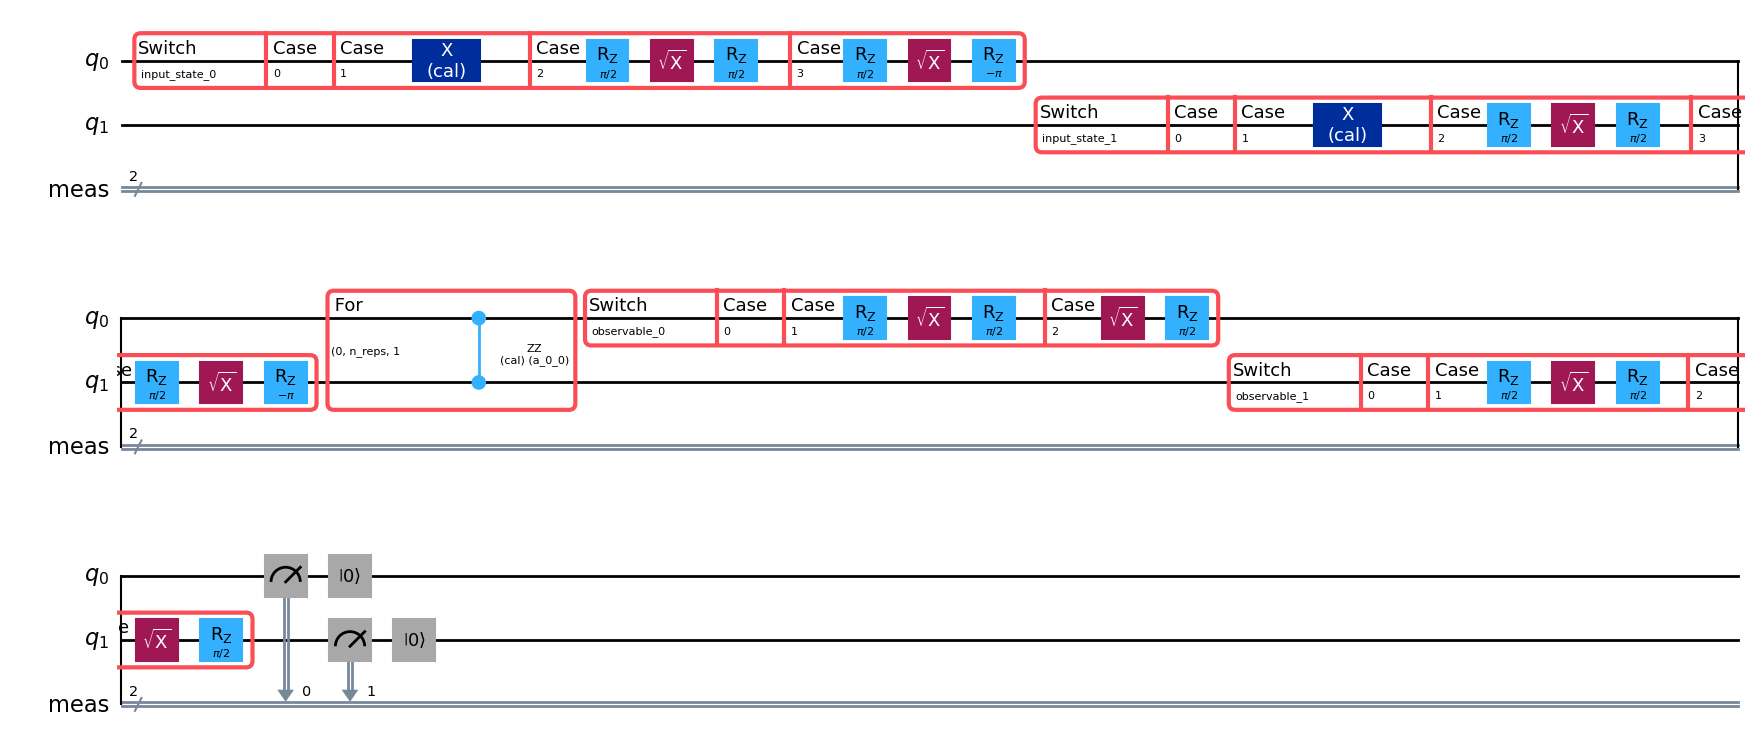

In [5]:
q_env.real_time_circuit.draw("mpl", idle_wires=False, with_layout=False)

In [6]:
print(backend.target)

Target: Transmon based QuAM
Number of qubits: 5
Instructions:
	x
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	rz
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	sx
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	measure
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	reset
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	delay
		(0,)
		(1,)
		(2,)
		(3,)
		(4,)
	cz
		(0, 1)
		(1, 2)
		(2, 3)
		(3, 4)
	if_else
	while_loop
	for_loop
	switch_case



In [7]:
q_env.real_time_circuit.calibrations

/var/folders/5w/ygx15jq94z5dzxwkmbbj8zfm0000gn/T/ipykernel_3364/620505994.py:1: DeprecationWarning: The property ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` is deprecated as of Qiskit 1.3. It will be removed in Qiskit 2.0. The entire Qiskit Pulse package is being deprecated and will be moved to the Qiskit Dynamics repository: https://github.com/qiskit-community/qiskit-dynamics. Note that once removed, ``qiskit.circuit.quantumcircuit.QuantumCircuit.calibrations`` will have no alternative in Qiskit.
  q_env.real_time_circuit.calibrations


{'rzz': {((0, 1),
   (Parameter(a_0_0),)): ScheduleBlock(Play(Constant(duration=120, amp=0.1, angle=0.0, name='block0_0'), FluxChannel(0)), Play(Constant(duration=120, amp=a_0_0, angle=0.0, name='block0_1'), ControlChannel(0)), name="block0", transform=AlignLeft())},
 'x': {((0,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_014771845584'), DriveChannel(0)), name="x_custom", transform=AlignLeft()),
  ((1,),
   ()): ScheduleBlock(Play(Drag(duration=120, sigma=40, beta=0.2, amp=0.3, angle=0.0, name='x_custom_014771845584'), DriveChannel(0)), name="x_custom", transform=AlignLeft())}}

In [7]:
from qm import generate_qua_script

prog = q_env.rl_qoc_training_qua_prog()
print(generate_qua_script(prog))


# Single QUA script generated at 2025-05-29 09:45:04.578823
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    input_stream_a_0_0 = declare_input_stream(fixed, 'a_0_0', value=0.0)
    input_stream_max_input_state = declare_input_stream(int, 'max_input_state', value=0)
    input_stream_input_state_0 = declare_input_stream(int, 'input_state_0', value=0)
    input_stream_mu = declare_input_stream(fixed, 'mu', value=[0.0])
    v1 = declare(int, )
    input_stream_sigma = declare_input_stream(fixed, 'sigma', value=[1.0])
    v2 = declare(int, )
    input_stream_reward = declare_input_stream(int, 'reward', value=[0, 0])
    v3 = declare(int, )
    input_stream_n_reps = declare_input_stream(int, 'n_reps', value=2)
    input_stream_observable_0 = declare_input_stream(int, 'observable_0', value=0)
    v4 = declare(int, )
    input_stream_max_observables = declare_input_stream(int, 'max_observables', value=0)
    input

In [7]:
from qiskit_qm_provider import QMInstructionProperties
from qiskit.circuit import Gate

x_test = Gate("x_test", 1, [])


def x_test_macro():
    machine.active_qubits[0].apply("x")


instruction_prop = QMInstructionProperties(qua_pulse_macro=x_test_macro)

In [8]:
backend.target.add_instruction(x_test, {(0,): instruction_prop})

In [14]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.primitives import StatevectorSampler
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_ibm_runtime.fake_provider import FakeJakartaV2
from qiskit import transpile

qreg = QuantumRegister(2, "q")
c1 = ClassicalRegister(2, "c1")
c2 = ClassicalRegister(1, "c2")
qc = QuantumCircuit(qreg, c1, c2)
qc.x(0)
qc.x(1)
qc.measure(0, c1[0])
qc.measure(0, c1[1])
qc.measure(1, c2[0])

sampler = StatevectorSampler()
job = sampler.run([(qc,)], shots=1000)
result = job.result()
fake_backend = FakeJakartaV2()
transpiled_circuit = transpile(qc, backend=fake_backend)
result2 = FakeJakartaV2().run([transpiled_circuit, transpiled_circuit], shots=1000).result()

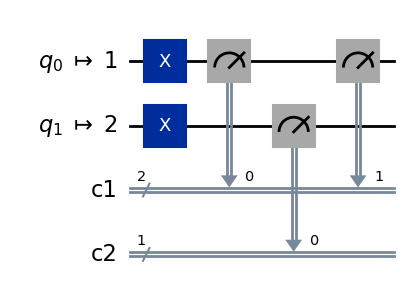

In [15]:
transpiled_circuit.draw("mpl")

In [17]:
result[0]

SamplerPubResult(data=DataBin(c1=BitArray(<shape=(), num_shots=1000, num_bits=2>), c2=BitArray(<shape=(), num_shots=1000, num_bits=1>)), metadata={'shots': 1000, 'circuit_metadata': {}})

In [111]:
result2.get_counts()

[{'0 01': 1, '0 11': 16, '1 10': 20, '1 01': 28, '1 11': 935},
 {'1 10': 23, '1 01': 16, '0 11': 18, '1 11': 943}]

In [116]:
result2

Result(backend_name='aer_simulator', backend_version='0.17.0', qobj_id='', job_id='8d7895d3-9053-4a79-a758-99d1d1ab6e89', success=True, results=[ExperimentResult(shots=1000, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 1, '0x3': 16, '0x6': 20, '0x5': 28, '0x7': 935}), header=QobjExperimentHeader(creg_sizes=[['c1', 2], ['c2', 1]], global_phase=0.0, memory_slots=3, n_qubits=7, name='circuit-2763', qreg_sizes=[['q', 7]], metadata={}), status=DONE, seed_simulator=3045177010, metadata={'num_bind_params': 1, 'runtime_parameter_bind': False, 'parallel_state_update': 12, 'parallel_shots': 1, 'sample_measure_time': 9.5791e-05, 'noise': 'superop', 'batched_shots_optimization': False, 'remapped_qubits': True, 'active_input_qubits': [1, 2], 'device': 'CPU', 'time_taken': 0.00073275, 'measure_sampling': True, 'num_clbits': 3, 'max_memory_mb': 18432, 'input_qubit_map': [[2, 1], [1, 0]], 'num_qubits': 2, 'method': 'density_matrix', 'required_memory_mb': 1, 'fusion': {'enabled'

In [38]:
qc.find_bit(qc.clbits[0])

BitLocations(index=0, registers=[(ClassicalRegister(3, 'c1'), 0)])

In [6]:
from pathlib import Path
import json
from qiskit_qm_provider import ParameterPool

path = Path.home() / "qm_saas_config.json"
with open(path, "r") as f:
    config = json.load(f)
email = config["email"]
password = config["password"]
# Initialize QOP simulator client
client = QmSaas(email=email, password=password, host="qm-saas.dev.quantum-machines.co")

# Choose your QOP version (QOP2.x.y or QOP3.x.y)
version = QoPVersion.latest
client.close_all()

In [13]:
from qm import SimulationConfig, LoopbackInterface

config = machine.generate_config()
instance = client.simulator(version=version)
instance.spawn()
# Initialize QuantumMachinesManager with the simulation instance details
qmm = QuantumMachinesManager(
    host=instance.host,
    port=instance.port,
    connection_headers=instance.default_connection_headers,
)
simulation_config = SimulationConfig(
    int(10000),
    include_analog_waveforms=True,
    simulation_interface=LoopbackInterface([("con1", 1, "con1", 1), ("con1", 2, "con1", 2)]),
)
backend.qmm = qmm
backend.set_options(simulate=simulation_config)

2025-05-26 15:43:12,684 - qm - INFO     - Performing health check
2025-05-26 15:43:12 INFO Performing health check
2025-05-26 15:43:12,998 - qm - INFO     - Cluster healthcheck completed successfully.
2025-05-26 15:43:12 INFO Cluster healthcheck completed successfully.


In [6]:
backend._qmm

In [ ]:
from qiskit.circuit import ClassicalRegister, QuantumRegister

qreg = QuantumRegister(3)
creg1 = ClassicalRegister(1, "c1")
creg2 = ClassicalRegister(2, "c2")
qc = QuantumCircuit(qreg, creg1, creg2)
qc.h(0)
qc.h(1)
qc.x(2)

qc.measure(qreg[0], creg1[0])
qc.measure(qreg[1], creg2[0])
qc.measure(qreg[2], creg2[1])
qc.reset(slice(0, 2))
qc.draw("mpl")

In [30]:
qc = transpile(qc, backend=backend, optimization_level=0)

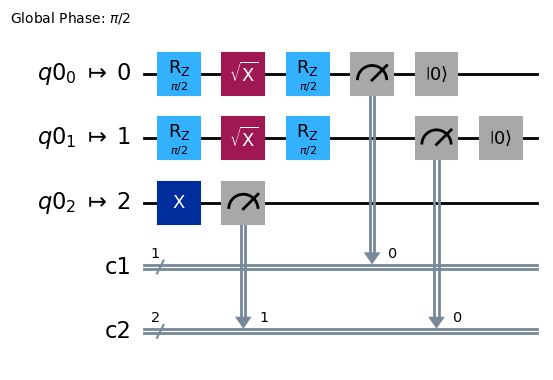

In [15]:
qc.draw("mpl")

In [16]:
qc.cregs

[ClassicalRegister(1, 'c1'), ClassicalRegister(2, 'c2')]

In [17]:
qc.layout.final_index_layout(True)

[0, 1, 2]

In [12]:
backend.qmm = iqcc

In [9]:
from qiskit_qm_provider.primitives.qm_sampler import QMSamplerV2, QMSamplerOptions
from qiskit_qm_provider.job.qua_programs import sampler_program
from qiskit.primitives.containers.sampler_pub import SamplerPub

pub = SamplerPub.coerce(qc, shots=100)
print(generate_qua_script(sampler_program(backend, [pub])))

NameError: name 'qc' is not defined

In [6]:
from qiskit_qm_provider.primitives.qm_sampler import QMSamplerV2, QMSamplerOptions

sampler = QMSamplerV2(backend, options=QMSamplerOptions(input_type="INPUT_STREAM"))

In [8]:
result = sampler.run([(qc, None, 1000)]).result()

NameError: name 'QMSamplerV2' is not defined

In [24]:
result[0].data.c1.get_counts()

{'0': 522, '1': 478}

In [25]:
result[0].data.c2.get_counts()

{'00': 64, '01': 64, '11': 426, '10': 446}

In [17]:
backend.run(qc, shots=100, timeout=600).result()

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1956: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


Output()

[20:17:31] QUA program submitted to arbel (id = e3e4617d-57fb-4777-ba9c-5c93d21ffcc9)              ]8;id=842394;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=264942;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#442\442]8;;\

[20:17:32] Execution started                                                                       ]8;id=990300;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=844537;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#462\462]8;;\

[20:18:32] Execution finished                                                                      ]8;id=752583;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=29405;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#476\476]8;;\

QUA program has error:

Execution timed out after 60

AttributeError: 'NoneType' object has no attribute 'to_bytes'

In [18]:
qc2 = qc.copy_empty_like()
qc2.reset([qc.qubits[i] for i in qc.layout.final_index_layout()])
new_qc = qc.compose(qc2, front=True)
print(generate_qua_script(backend.get_run_program(1000, [new_qc])))


# Single QUA script generated at 2025-05-27 20:18:47.272563
# QUA library version: 1.2.2rc2+dgx2


from qm import CompilerOptionArguments
from qm.qua import *

with program() as prog:
    v1 = declare(int, )
    v2 = declare(int, value=0)
    a1 = declare(bool, value=[False, False, False])
    v3 = declare(fixed, )
    v4 = declare(fixed, )
    v5 = declare(bool, )
    v6 = declare(int, value=1)
    v7 = declare(fixed, )
    v8 = declare(fixed, )
    v9 = declare(bool, )
    v10 = declare(int, value=1)
    v11 = declare(fixed, )
    v12 = declare(fixed, )
    v13 = declare(bool, )
    v14 = declare(int, value=1)
    v15 = declare(bool, )
    v16 = declare(fixed, )
    v17 = declare(fixed, )
    v18 = declare(bool, )
    v19 = declare(fixed, )
    v20 = declare(fixed, )
    v21 = declare(bool, )
    v22 = declare(fixed, )
    v23 = declare(fixed, )
    set_dc_offset("qC1.z", "single", 0.03893272398522141)
    set_dc_offset("qC2.z", "single", 0.042361833295726854)
    set_dc_offset("qC3

In [9]:
machine.active_qubits[1].macros["reset"]

ResetMacro(id='reset', reset_type='active', pi_pulse='x180', readout_pulse='readout', max_attempts=5, thermalize_time=0)

In [58]:
machine.active_qubits[5].T1

1.5818728339088663e-05

In [4]:
from qualang_tools.units import unit

u = unit(coerce_to_integer=True)
for qubit in machine.active_qubits:
    qubit.macros["reset"].reset_type = "thermalize"
    qubit.macros["reset"].thermalize_time = 5 * qubit.T1 * u.s

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_tools/units/units.py:60: RuntimeWarning: Warning: the specified duration (0.00016321692632583217) to be converted to clock cycles in not an integer. It has been converted to int (163216.0) to avoid subsequent errors.
  warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_tools/units/units.py:60: RuntimeWarning: Warning: the specified duration (0.00014101878302276747) to be converted to clock cycles in not an integer. It has been converted to int (141018.0) to avoid subsequent errors.
  warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_tools/units/units.py:60: RuntimeWarning: Warning: the specified duration (0.0001557610809036357) to be converted to clock cycles in not an integer. It has been converted to int (155761.0) to avoid subsequent errors.
  warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qualang_to

2025-06-02 22:57:47 INFO Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)
2025-06-02 22:57:47 INFO Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)
2025-06-02 22:57:47 INFO Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)
2025-06-02 22:57:47 INFO Could not load 'ibm_dynamic_circuits': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qiskit/providers/__init__.py)
2025-06-02 22:57:47 INFO Could not load 'ibm_backend': cannot import name 'ProviderV1' from 'qiskit.providers' (/Users/art

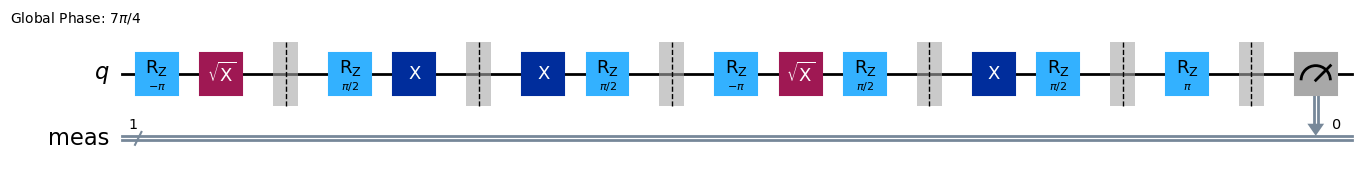

In [9]:
from qiskit_experiments.library.randomized_benchmarking import StandardRB
from qiskit_qm_provider.primitives.qm_sampler import QMSamplerV2, QMSamplerOptions

sampler = QMSamplerV2(
    backend,
    options=QMSamplerOptions(
        input_type="INPUT_STREAM",
    ),
)
exp = StandardRB([0], [5, 30, 60, 90, 120], backend=backend, num_samples=5)
exp._transpiled_circuits()[0].draw("mpl")

In [10]:
exp._transpiled_circuits()[0].qubits

[<Qubit register=(1, "q"), index=0>]

In [15]:
exp_data = exp.run(sampler=sampler, backend_run=True)

/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/quam/components/channels.py:647: UserWarning: The 'thread' element argument is deprecated from qm.qua >= 1.2.2. Use 'core' instead.
  warnings.warn(
/Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/qm/program/_qua_config_schema.py:1956: DeprecationWarning: 'version' is deprecated since "1.2.2" and will be removed in "1.3.0". Please remove it from the Qua config.
  warnings.warn(


Output()

[23:05:26] QUA program submitted to gilboa (id = 1b5cd055-262e-4ca2-8c3e-80d30de8a09c)             ]8;id=10714;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=827972;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#442\442]8;;\

           Execution started                                                                       ]8;id=619822;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=731833;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#462\462]8;;\

[23:06:33] Execution finished                                                                      ]8;id=100465;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py\computers.py]8;;\:]8;id=301804;file:///Users/arthurostrauss/anaconda3/envs/rl_qoc/lib/python3.11/site-packages/iqcc_cloud_client/computers.py#476\476]8;;\

QUA program has error:

Traceback (most recent call last):
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 369, in recv_initial_metadata
    headers = await self._stream.recv_headers()
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/grpclib/protocol.py", line 342, in recv_headers
    await self.headers_received.wait()
  File "/usr/local/lib/python3.11/asyncio/locks.py", line 213, in wait
    await fut
asyncio.exceptions.CancelledError

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/app/temp.py", line 27772, in <module>
    qm_job = qm.execute(prog)
             ^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qm_api_old.py", line 173, in execute
    new_job_api = self.add_to_queue(program, compiler_options=compiler_options)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qm_api.py", line 242, in add_to_queue
    return self._add_program(program)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/qm_api.py", line 195, in _add_program
    response = self._run(self._stub.add_to_queue(request, timeout=self._timeout))
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 76, in wrapped
    raise e
  File "/app/.venv/lib/python3.11/site-packages/qm/api/base_api.py", line 53, in wrapped
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/api/v2/base_api_v2.py", line 22, in _run
    response = run_async(coroutine)
               ^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/qm/utils/async_utils.py", line 38, in run_async
    return create_future(coroutine).result()  # type: ignore
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/concurrent/futures/_base.py", line 456, in result
    return self.__get_result()
           ^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/concurrent/futures/_base.py", line 401, in __get_result
    raise self._exception
  File "/app/.venv/lib/python3.11/site-packages/qm/grpc/v2/__init__.py", line 1998, in add_to_queue
    return await self._unary_unary(
           ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/betterproto/grpc/grpclib_client.py", line 85, in _unary_unary
    response = await stream.recv_message()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 426, in recv_message
    await self.recv_initial_metadata()
  File "/app/.venv/lib/python3.11/site-packages/grpclib/client.py", line 368, in recv_initial_metadata
    with self._wrapper:
  File "/app/.venv/lib/python3.11/site-packages/grpclib/utils.py", line 70, in __exit__
    raise self._error
grpclib.exceptions.StreamTerminatedError: Stream reset by remote party, error_code: 8

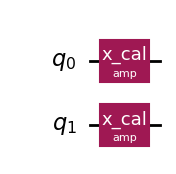

In [34]:
from qiskit.circuit import QuantumCircuit, Parameter, Gate

physical_qubits = (1, 2)
qc = QuantumCircuit(2)
amp = Parameter("amp")
gate = Gate("x_cal", 1, [amp])
qc.append(gate, [0])
qc.append(gate, [1])
qc.draw("mpl")

In [ ]:
from qiskit_qm_provider import QMInstructionProperties
from qm.qua import *


def play_custom_x_1(amp):
    machine.active_qubits[physical_qubits[0]].xy.play("x180", amplitude_scale=amp)


def play_custom_x_2(amp):
    machine.active_qubits[physical_qubits[1]].xy.play("x180", amplitude_scale=amp)


instruction_prop1 = QMInstructionProperties(qua_pulse_macro=play_custom_x_1)
instruction_prop2 = QMInstructionProperties(qua_pulse_macro=play_custom_x_2)

backend.target.add_instruction(gate, {0: instruction_prop1, 1: instruction_prop2})